In [75]:
!python -m venv torch-gpu
!torch-gpu\Scripts\activate

In [76]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [77]:
import os
import sys
import json
import numpy as np
from PIL import Image
import cv2
import copy
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("="*80)
print("ENVIRONMENT SETUP")
print("="*80)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("="*80)

ENVIRONMENT SETUP
PyTorch version: 2.1.2+cu121
CUDA available: True
CUDA version: 12.1
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


Config

In [78]:
class Config:
    """Centralized configuration for the entire pipeline."""

    # Paths
    IMG_ROOT = 'D:/Detectron/idd20kII/idd20kII/leftImg8bit/train'
    GT_ROOT = 'D:/Detectron/idd20kII/idd20kII/gtFine/train'
    PAN_ROOT = 'D:/Detectron/idd20kII/idd_panoptic/train'
    SEM_ROOT = 'D:/Detectron/idd20kII/idd_semantic/train'
    JSON_OUT = 'D:/Detectron/idd20kII/panoptic_train.json'
    OUTPUT_DIR = 'D:/Detectron/idd20kII/output'

    # Training parameters
    LIMIT = None  # Set to integer for testing (e.g., 50), None for full dataset
    BATCH_SIZE = 2
    BASE_LR = 0.00025
    MAX_ITER = 8000   # Adjust based on dataset size
    WARMUP_ITERS = 100
    CHECKPOINT_PERIOD = 250

    # Model parameters
    MIN_SIZE_TRAIN = (640, 672, 704, 736, 768, 800)
    MAX_SIZE_TRAIN = 1333
    MIN_SIZE_TEST = 800
    MAX_SIZE_TEST = 1333

    # Data augmentation
    HORIZONTAL_FLIP_PROB = 0.5

    # Validation
    EVAL_PERIOD = 250  # Evaluate every N iterations

    # Device
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

cfg = Config()

# Create directories
for path in [cfg.PAN_ROOT, cfg.SEM_ROOT, cfg.OUTPUT_DIR]:
    os.makedirs(path, exist_ok=True)

print("\n" + "="*80)
print("CONFIGURATION")
print("="*80)
print(f"Images:         {cfg.IMG_ROOT}")
print(f"Ground truth:   {cfg.GT_ROOT}")
print(f"Panoptic out:   {cfg.PAN_ROOT}")
print(f"Semantic out:   {cfg.SEM_ROOT}")
print(f"JSON out:       {cfg.JSON_OUT}")
print(f"Model out:      {cfg.OUTPUT_DIR}")
print(f"Batch size:     {cfg.BATCH_SIZE}")
print(f"Max iterations: {cfg.MAX_ITER}")
print(f"Learning rate:  {cfg.BASE_LR}")
print(f"Device:         {cfg.DEVICE}")
print(f"Data limit:     {cfg.LIMIT if cfg.LIMIT else 'Full dataset'}")
print("="*80)


CONFIGURATION
Images:         D:/Detectron/idd20kII/idd20kII/leftImg8bit/train
Ground truth:   D:/Detectron/idd20kII/idd20kII/gtFine/train
Panoptic out:   D:/Detectron/idd20kII/idd_panoptic/train
Semantic out:   D:/Detectron/idd20kII/idd_semantic/train
JSON out:       D:/Detectron/idd20kII/panoptic_train.json
Model out:      D:/Detectron/idd20kII/output
Batch size:     2
Max iterations: 8000
Learning rate:  0.00025
Device:         cuda
Data limit:     Full dataset


IDD20kTaxonomy

In [79]:
"""
Complete IDD20K Level-3 class taxonomy.
These are REFERENCE IDs - we'll create contiguous mappings later.
"""

IDD_TAXONOMY = {
    # Drivable surfaces
    'road': {'original_id': 0, 'isthing': 0, 'category': 'drivable', 'color': [128, 64, 128]},
    'parking': {'original_id': 1, 'isthing': 0, 'category': 'drivable', 'color': [250, 170, 160]},
    'drivable fallback': {'original_id': 2, 'isthing': 0, 'category': 'drivable', 'color': [81, 0, 81]},

    # Non-drivable surfaces
    'sidewalk': {'original_id': 3, 'isthing': 0, 'category': 'non-drivable', 'color': [244, 35, 232]},
    'rail track': {'original_id': 4, 'isthing': 0, 'category': 'non-drivable', 'color': [230, 150, 140]},
    'non-drivable fallback': {'original_id': 5, 'isthing': 0, 'category': 'non-drivable', 'color': [152, 251, 152]},

    # Living beings (things)
    'person': {'original_id': 6, 'isthing': 1, 'category': 'living', 'color': [220, 20, 60]},
    'animal': {'original_id': 7, 'isthing': 1, 'category': 'living', 'color': [246, 198, 145]},
    'rider': {'original_id': 8, 'isthing': 1, 'category': 'living', 'color': [255, 0, 0]},

    # Vehicles (things)
    'motorcycle': {'original_id': 9, 'isthing': 1, 'category': 'vehicle', 'color': [0, 0, 230]},
    'bicycle': {'original_id': 10, 'isthing': 1, 'category': 'vehicle', 'color': [119, 11, 32]},
    'autorickshaw': {'original_id': 11, 'isthing': 1, 'category': 'vehicle', 'color': [255, 204, 54]},
    'car': {'original_id': 12, 'isthing': 1, 'category': 'vehicle', 'color': [0, 0, 142]},
    'truck': {'original_id': 13, 'isthing': 1, 'category': 'vehicle', 'color': [0, 0, 70]},
    'bus': {'original_id': 14, 'isthing': 1, 'category': 'vehicle', 'color': [0, 60, 100]},
    'caravan': {'original_id': 15, 'isthing': 1, 'category': 'vehicle', 'color': [0, 0, 90]},
    'trailer': {'original_id': 16, 'isthing': 1, 'category': 'vehicle', 'color': [0, 0, 110]},
    'train': {'original_id': 17, 'isthing': 1, 'category': 'vehicle', 'color': [0, 80, 100]},
    'vehicle fallback': {'original_id': 18, 'isthing': 1, 'category': 'vehicle', 'color': [136, 143, 153]},

    # Roadside objects
    'curb': {'original_id': 19, 'isthing': 0, 'category': 'roadside', 'color': [220, 190, 40]},
    'wall': {'original_id': 20, 'isthing': 0, 'category': 'roadside', 'color': [102, 102, 156]},
    'fence': {'original_id': 21, 'isthing': 0, 'category': 'roadside', 'color': [190, 153, 153]},
    'guard rail': {'original_id': 22, 'isthing': 0, 'category': 'roadside', 'color': [180, 165, 180]},
    'billboard': {'original_id': 23, 'isthing': 0, 'category': 'roadside', 'color': [174, 64, 67]},
    'traffic sign': {'original_id': 24, 'isthing': 1, 'category': 'roadside', 'color': [220, 220, 0]},
    'traffic light': {'original_id': 25, 'isthing': 1, 'category': 'roadside', 'color': [250, 170, 30]},
    'pole': {'original_id': 26, 'isthing': 0, 'category': 'roadside', 'color': [153, 153, 153]},
    'polegroup': {'original_id': 27, 'isthing': 0, 'category': 'roadside', 'color': [169, 187, 214]},
    'obs-str-bar-fallback': {'original_id': 28, 'isthing': 0, 'category': 'roadside', 'color': [70, 70, 70]},

    # Constructions
    'building': {'original_id': 29, 'isthing': 0, 'category': 'construction', 'color': [70, 70, 70]},
    'bridge': {'original_id': 30, 'isthing': 0, 'category': 'construction', 'color': [150, 100, 100]},
    'tunnel': {'original_id': 31, 'isthing': 0, 'category': 'construction', 'color': [150, 120, 90]},

    # Nature
    'vegetation': {'original_id': 32, 'isthing': 0, 'category': 'nature', 'color': [107, 142, 35]},
    'sky': {'original_id': 33, 'isthing': 0, 'category': 'nature', 'color': [70, 130, 180]},
    'fallback background': {'original_id': 34, 'isthing': 0, 'category': 'nature', 'color': [169, 187, 214]},

    # Void classes
    'unlabeled': {'original_id': 35, 'isthing': 0, 'category': 'void', 'color': [0, 0, 0]},
    'ego vehicle': {'original_id': 36, 'isthing': 0, 'category': 'void', 'color': [0, 0, 0]},
    'rectification border': {'original_id': 37, 'isthing': 0, 'category': 'void', 'color': [0, 0, 0]},
    'out of roi': {'original_id': 38, 'isthing': 0, 'category': 'void', 'color': [0, 0, 0]},
    'license plate': {'original_id': 39, 'isthing': 0, 'category': 'void', 'color': [0, 0, 142]},
}

print("\n" + "="*80)
print("IDD20K TAXONOMY LOADED")
print("="*80)
print(f"Total classes defined: {len(IDD_TAXONOMY)}")
print(f"Thing classes: {sum(1 for v in IDD_TAXONOMY.values() if v['isthing'] == 1)}")
print(f"Stuff classes: {sum(1 for v in IDD_TAXONOMY.values() if v['isthing'] == 0)}")
print("="*80)


IDD20K TAXONOMY LOADED
Total classes defined: 40
Thing classes: 15
Stuff classes: 25


Validation

In [80]:
print("\n" + "="*80)
print("VALIDATING DATA")
print("="*80)

# Check paths exist
assert os.path.isdir(cfg.IMG_ROOT), f"Images not found: {cfg.IMG_ROOT}"
assert os.path.isdir(cfg.GT_ROOT), f"Ground truth not found: {cfg.GT_ROOT}"

# Count cities and files
img_cities = [d for d in os.listdir(cfg.IMG_ROOT) if os.path.isdir(os.path.join(cfg.IMG_ROOT, d))]
gt_cities = [d for d in os.listdir(cfg.GT_ROOT) if os.path.isdir(os.path.join(cfg.GT_ROOT, d))]

print(f"✓ Image directories: {len(img_cities)}")
print(f"✓ GT directories: {len(gt_cities)}")

# Sample verification
if img_cities:
    sample_city = img_cities[0]
    sample_imgs = [f for f in os.listdir(os.path.join(cfg.IMG_ROOT, sample_city)) if f.endswith('.jpg')]
    sample_gts = [f for f in os.listdir(os.path.join(cfg.GT_ROOT, sample_city)) if f.endswith('.json')]
    print(f"✓ Sample city '{sample_city}': {len(sample_imgs)} images, {len(sample_gts)} annotations")

print("="*80)


VALIDATING DATA
✓ Image directories: 249
✓ GT directories: 249
✓ Sample city '201': 11 images, 11 annotations


Class discovery and stats

In [81]:
print("DISCOVERING CLASSES IN DATASET")
print("="*80)

classes_found = set()
class_counts = Counter()
sample_limit = 50  # Sample files to get statistics

for city in tqdm(sorted(os.listdir(cfg.GT_ROOT)), desc="Scanning cities"):
    city_gt = os.path.join(cfg.GT_ROOT, city)
    if not os.path.isdir(city_gt):
        continue

    for json_file in os.listdir(city_gt):
        if not json_file.endswith('_gtFine_polygons.json'):
            continue

        if len(classes_found) > 0 and class_counts.total() >= sample_limit * 50:
            break

        try:
            with open(os.path.join(city_gt, json_file), 'r') as f:
                data = json.load(f)

            for obj in data.get('objects', []):
                label = obj.get('label', '')
                if label and label in IDD_TAXONOMY:
                    classes_found.add(label)
                    class_counts[label] += 1
        except Exception as e:
            print(f"Warning: Error reading {json_file}: {e}")
            continue

    if len(classes_found) > 0 and class_counts.total() >= sample_limit * 50:
        break

print(f"\nFound {len(classes_found)} unique classes in dataset")
print(f"Sampled {class_counts.total()} object instances\n")

# Display class distribution
print("Class distribution (top 15):")
print(f"{'Class':<30} {'Count':>8} {'Type':>10} {'Original ID':>12}")
print("-" * 70)
for cls, count in class_counts.most_common(15):
    info = IDD_TAXONOMY[cls]
    cls_type = "THING" if info['isthing'] else "STUFF"
    print(f"{cls:<30} {count:>8} {cls_type:>10} {info['original_id']:>12}")

print("="*80)

DISCOVERING CLASSES IN DATASET


Scanning cities:   1%|          | 3/249 [00:01<02:35,  1.58it/s]


Found 24 unique classes in dataset
Sampled 2565 object instances

Class distribution (top 15):
Class                             Count       Type  Original ID
----------------------------------------------------------------------
vegetation                          687      STUFF           32
obs-str-bar-fallback                596      STUFF           28
pole                                380      STUFF           26
motorcycle                          119      THING            9
building                             85      STUFF           29
non-drivable fallback                84      STUFF            5
drivable fallback                    81      STUFF            2
person                               66      THING            6
rider                                65      THING            8
billboard                            60      STUFF           23
car                                  57      THING           12
sky                                  40      STUFF           33
r

Mapping

In [82]:
print("\n" + "="*80)
print("CREATING CONTIGUOUS CLASS ID MAPPING")
print("="*80)
print("This fixes CUDA device-side assert errors!\n")

# Sort classes by original IDD ID to maintain semantic ordering
classes_sorted = sorted(
    list(classes_found),
    key=lambda x: IDD_TAXONOMY[x]['original_id']
)

# Create mappings
class_name_to_contiguous_id = {}
contiguous_id_to_class_name = {}
category_list = []
thing_contiguous_ids = []
stuff_contiguous_ids = []

print(f"{'Class Name':<30} {'Original ID':>13} → {'Contiguous ID':>15} {'Type':>8}")
print("-" * 80)

for contiguous_id, class_name in enumerate(classes_sorted):
    info = IDD_TAXONOMY[class_name]
    original_id = info['original_id']
    isthing = info['isthing']

    # Store mappings
    class_name_to_contiguous_id[class_name] = contiguous_id
    contiguous_id_to_class_name[contiguous_id] = class_name

    # Create category entry with CONTIGUOUS ID
    category_list.append({
        'id': contiguous_id,  # ← CONTIGUOUS: 0, 1, 2, ...
        'name': class_name,
        'supercategory': info['category'],
        'isthing': isthing,
        'color': info['color'],
        'original_idd_id': original_id  # Keep for reference
    })

    # Track thing vs stuff
    if isthing == 1:
        thing_contiguous_ids.append(contiguous_id)
    else:
        stuff_contiguous_ids.append(contiguous_id)

    cls_type = "THING" if isthing else "STUFF"
    print(f"{class_name:<30} {original_id:>13} → {contiguous_id:>15} {cls_type:>8}")

num_classes_total = len(classes_sorted)
num_thing_classes = len(thing_contiguous_ids)
num_stuff_classes = len(stuff_contiguous_ids)

thing_class_names = [
    c for c in classes_sorted
    if IDD_TAXONOMY[c]['isthing'] == 1
]

thing_name_to_id = {
    name: i for i, name in enumerate(thing_class_names)
}

print("\nTHING-ONLY CLASS MAPPING")
print("-" * 60)
for name, idx in thing_name_to_id.items():
    print(f"{name:<25} → {idx}")

print(f"\nTotal thing classes: {len(thing_class_names)}")
print("-" * 60)

print("\n" + "="*80)
print("MAPPING SUMMARY")
print("="*80)
print(f"Total classes:      {num_classes_total}")
print(f"Thing classes:      {num_thing_classes}")
print(f"Stuff classes:      {num_stuff_classes}")
print(f"Contiguous range:   0 to {num_classes_total - 1}")
print(f"✓ All IDs are now contiguous (fixes CUDA error!)")
print("="*80)


CREATING CONTIGUOUS CLASS ID MAPPING
This fixes CUDA device-side assert errors!

Class Name                       Original ID →   Contiguous ID     Type
--------------------------------------------------------------------------------
road                                       0 →               0    STUFF
drivable fallback                          2 →               1    STUFF
non-drivable fallback                      5 →               2    STUFF
person                                     6 →               3    THING
animal                                     7 →               4    THING
rider                                      8 →               5    THING
motorcycle                                 9 →               6    THING
bicycle                                   10 →               7    THING
autorickshaw                              11 →               8    THING
car                                       12 →               9    THING
truck                                     13 

Polygon to mask

In [83]:
def polygon_to_mask(polygon, height, width, fill_value):
    """
    Convert a polygon to a binary mask.

    Args:
        polygon: List of polygon points in various formats
        height: Image height
        width: Image width
        fill_value: Value to fill the polygon with

    Returns:
        mask: numpy array of shape (height, width)
    """
    mask = np.zeros((height, width), dtype=np.int32)

    if not polygon or len(polygon) < 3:
        return mask

    try:
        # Handle different polygon formats
        if isinstance(polygon[0], list):
            # Format: [[x1, y1], [x2, y2], ...]
            points = np.array(polygon, dtype=np.int32)
        elif isinstance(polygon[0], (int, float)):
            # Format: [x1, y1, x2, y2, ...]
            if len(polygon) < 6:  # Need at least 3 points
                return mask
            points = np.array(polygon).reshape(-1, 2).astype(np.int32)
        else:
            return mask

        # Ensure points are within image bounds
        points[:, 0] = np.clip(points[:, 0], 0, width - 1)
        points[:, 1] = np.clip(points[:, 1], 0, height - 1)

        # Fill polygon
        cv2.fillPoly(mask, [points], int(fill_value))

    except Exception as e:
        print(f"Warning: Failed to create mask: {e}")
        return mask

    return mask

def calculate_bbox(mask, instance_id):
    """Calculate bounding box from instance mask."""
    ys, xs = np.where(mask == instance_id)
    if len(xs) == 0:
        return None

    x_min = int(xs.min())
    x_max = int(xs.max())
    y_min = int(ys.min())
    y_max = int(ys.max())

    return [x_min, y_min, x_max - x_min + 1, y_max - y_min + 1]

print("✓ Polygon utilities defined")

✓ Polygon utilities defined


gen masks

In [84]:
print("\n" + "="*80)
print("GENERATING PANOPTIC AND SEMANTIC MASKS")
print("="*80)

images_list = []
annotations_list = []
img_id = 0
total_processed = 0
total_skipped = 0
total_instances = 0
instance_counts = Counter()
skipped_reasons = Counter()

for city in tqdm(sorted(os.listdir(cfg.GT_ROOT)), desc="Processing cities"):
    city_gt = os.path.join(cfg.GT_ROOT, city)
    city_img = os.path.join(cfg.IMG_ROOT, city)
    city_pan = os.path.join(cfg.PAN_ROOT, city)
    city_sem = os.path.join(cfg.SEM_ROOT, city)

    if not os.path.isdir(city_gt) or not os.path.isdir(city_img):
        continue

    # Create output directories
    os.makedirs(city_pan, exist_ok=True)
    os.makedirs(city_sem, exist_ok=True)

    for json_file in sorted(os.listdir(city_gt)):
        if not json_file.endswith('_gtFine_polygons.json'):
            continue

        # Check limit
        if cfg.LIMIT is not None and total_processed >= cfg.LIMIT:
            break

        # Get corresponding image
        base_name = json_file.replace('_gtFine_polygons.json', '')
        img_name = base_name + '_leftImg8bit.jpg'
        img_path = os.path.join(city_img, img_name)

        if not os.path.exists(img_path):
            total_skipped += 1
            skipped_reasons['no_image'] += 1
            continue

        try:
            # Load image to get dimensions
            img = Image.open(img_path)
            img_width, img_height = img.size

            # Load annotations
            json_path = os.path.join(city_gt, json_file)
            with open(json_path, 'r') as f:
                gt_data = json.load(f)

            # Initialize masks
            panoptic_mask = np.zeros((img_height, img_width), dtype=np.int32)
            semantic_mask = np.zeros((img_height, img_width), dtype=np.int8)
            segments_info = []

            instance_id = 1  # Start from 1 (0 is reserved for background)

            # Process each object
            for obj in gt_data.get('objects', []):
                label = obj.get('label', '')

                # Skip if class not in our contiguous mapping
                if label not in class_name_to_contiguous_id:
                    continue

                # Get CONTIGUOUS category ID
                category_id = class_name_to_contiguous_id[label]

                # Get polygon
                polygon = obj.get('polygon', [])
                if not polygon or len(polygon) < 3:
                    continue

                # Create instance mask
                instance_mask = polygon_to_mask(polygon, img_height, img_width, instance_id)

                # Check if mask is valid
                if instance_mask.sum() == 0:
                    continue

                # Add to panoptic mask
                panoptic_mask[instance_mask == instance_id] = instance_id

                # Add to semantic mask with CONTIGUOUS ID
                semantic_mask[instance_mask == instance_id] = category_id

                # Calculate bbox and area
                bbox = calculate_bbox(instance_mask, instance_id)
                if bbox is None:
                    continue

                area = int(np.sum(instance_mask == instance_id))

                # Store segment info
                segments_info.append({
                    'id': int(instance_id),
                    'category_id': int(category_id),  # ← CONTIGUOUS ID
                    'area': area,
                    'bbox': bbox,
                    'iscrowd': 0
                })

                instance_counts[label] += 1
                instance_id += 1
                total_instances += 1

            # Skip images with no valid instances
            if len(segments_info) == 0:
                total_skipped += 1
                skipped_reasons['no_instances'] += 1
                continue

            # Save panoptic mask (32-bit)
            pan_name = base_name + '_leftImg8bit.png'
            pan_path = os.path.join(city_pan, pan_name)
            Image.fromarray(panoptic_mask, mode='I').save(pan_path)

            # Save semantic mask (8-bit)
            sem_name = base_name + '_leftImg8bit.png'
            sem_path = os.path.join(city_sem, sem_name)
            Image.fromarray(semantic_mask).save(sem_path)

            # Add to dataset
            images_list.append({
                'id': img_id,
                'file_name': city + '/' + img_name,
                'height': img_height,
                'width': img_width
            })

            annotations_list.append({
                'image_id': img_id,
                'file_name': city + '/' + pan_name,
                'segments_info': segments_info
            })

            total_processed += 1
            img_id += 1

        except Exception as e:
            print(f"\nError processing {json_file}: {e}")
            total_skipped += 1
            skipped_reasons['error'] += 1
            continue

    if cfg.LIMIT is not None and total_processed >= cfg.LIMIT:
        break

# Create COCO panoptic JSON
panoptic_json = {
    'images': images_list,
    'annotations': annotations_list,
    'categories': category_list
}

# Save JSON
with open(cfg.JSON_OUT, 'w') as f:
    json.dump(panoptic_json, f, indent=2)

print("\n" + "="*80)
print("MASK GENERATION COMPLETE")
print("="*80)
print(f"Images processed:     {total_processed}")
print(f"Images skipped:       {total_skipped}")
print(f"  No image:           {skipped_reasons['no_image']}")
print(f"  No instances:       {skipped_reasons['no_instances']}")
print(f"  Errors:             {skipped_reasons['error']}")
print(f"Total instances:      {total_instances}")
print(f"Avg instances/image:  {total_instances/max(total_processed, 1):.1f}")

print(f"\nClass distribution (top 10):")
for cls, count in instance_counts.most_common(10):
    cat_id = class_name_to_contiguous_id[cls]
    isthing = "THING" if IDD_TAXONOMY[cls]['isthing'] else "STUFF"
    print(f"  {cls:<30} {count:>6} [ID:{cat_id:>2}] [{isthing}]")

print(f"\nFiles saved:")
print(f"  Panoptic masks: {cfg.PAN_ROOT}")
print(f"  Semantic masks: {cfg.SEM_ROOT}")
print(f"  JSON metadata:  {cfg.JSON_OUT}")
print("="*80)


GENERATING PANOPTIC AND SEMANTIC MASKS


Processing cities: 100%|██████████| 249/249 [3:05:06<00:00, 44.60s/it]    



MASK GENERATION COMPLETE
Images processed:     7034
Images skipped:       0
  No image:           0
  No instances:       0
  Errors:             0
Total instances:      701701
Avg instances/image:  99.8

Class distribution (top 10):
  obs-str-bar-fallback           149667 [ID:19] [STUFF]
  vegetation                     140821 [ID:21] [STUFF]
  pole                            91716 [ID:18] [STUFF]
  billboard                       42264 [ID:16] [STUFF]
  motorcycle                      40454 [ID: 6] [THING]
  rider                           35555 [ID: 5] [THING]
  person                          28990 [ID: 3] [THING]
  car                             26416 [ID: 9] [THING]
  building                        24410 [ID:20] [STUFF]
  vehicle fallback                18994 [ID:12] [THING]

Files saved:
  Panoptic masks: D:/Detectron/idd20kII/idd_panoptic/train
  Semantic masks: D:/Detectron/idd20kII/idd_semantic/train
  JSON metadata:  D:/Detectron/idd20kII/panoptic_train.json


Verfication

In [85]:
print("\n" + "="*80)
print("CRITICAL VERIFICATION (Prevents CUDA Errors)")
print("="*80)

# Load a sample semantic mask
if len(images_list) > 0:
    sample_img = images_list[0]
    sem_file = sample_img['file_name'].replace('.jpg', '.png')
    sem_path = os.path.join(cfg.SEM_ROOT, sem_file)
    sem_mask = np.array(Image.open(sem_path))

    print(f"Sample file: {sample_img['file_name']}")
    print(f"Mask shape:  {sem_mask.shape}")
    print(f"Mask dtype:  {sem_mask.dtype}")
    print(f"Min value:   {sem_mask.min()}")
    print(f"Max value:   {sem_mask.max()}")
    print(f"Unique IDs:  {sorted(np.unique(sem_mask))}")
    print(f"\nExpected range: 0 to {num_classes_total - 1}")
    print(f"Model will use: {num_classes_total} classes")

    # CRITICAL CHECK
    if sem_mask.max() >= num_classes_total:
        raise ValueError(
            f"\n{'='*80}\n"
            f"❌ CRITICAL ERROR: CUDA CRASH IMMINENT!\n"
            f"{'='*80}\n"
            f"Max mask ID ({sem_mask.max()}) >= NUM_CLASSES ({num_classes_total})\n"
            f"This will cause 'CUDA device-side assert' error during training.\n"
            f"{'='*80}"
        )

    print(f"\n✅ VERIFICATION PASSED!")
    print(f"All mask values are in valid range [0, {num_classes_total-1}]")
    print("="*80)
else:
    print("⚠️  No images processed - cannot verify")
    print("="*80)


CRITICAL VERIFICATION (Prevents CUDA Errors)
Sample file: 201/frame0029_leftImg8bit.jpg
Mask shape:  (1080, 1920)
Mask dtype:  uint16
Min value:   0
Max value:   22
Unique IDs:  [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 16, 18, 19, 20, 21, 22]

Expected range: 0 to 23
Model will use: 24 classes

✅ VERIFICATION PASSED!
All mask values are in valid range [0, 23]


import detectron2

In [86]:
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
from detectron2.structures import BitMasks, Instances, Boxes
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_train_loader
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.evaluation import COCOPanopticEvaluator
import detectron2.utils.comm as comm

print("✓ Detectron2 imported successfully")

✓ Detectron2 imported successfully


Mapper

In [87]:
class PanopticDataMapper:
    def __init__(self, cfg_obj, is_train=True):
        self.is_train = is_train
        self.image_format = "BGR"

        if is_train:
            self.augmentations = T.AugmentationList([
                T.ResizeShortestEdge(
                    cfg.MIN_SIZE_TRAIN,
                    cfg.MAX_SIZE_TRAIN,
                    "choice"
                ),
                T.RandomFlip(
                    prob=cfg.HORIZONTAL_FLIP_PROB,
                    horizontal=True,
                    vertical=False
                )
            ])
        else:
            self.augmentations = T.AugmentationList([
                T.ResizeShortestEdge(
                    cfg.MIN_SIZE_TEST,
                    cfg.MAX_SIZE_TEST,
                    "choice"
                )
            ])

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)

        # ------------------ IMAGE ------------------
        image_path = os.path.join(cfg.IMG_ROOT, dataset_dict['file_name'])
        image = utils.read_image(image_path, format=self.image_format)
        utils.check_image_size(dataset_dict, image)

        # ------------------ SEMANTIC ------------------
        sem_file = dataset_dict['file_name'].replace('.jpg', '.png')
        sem_path = os.path.join(cfg.SEM_ROOT, sem_file)
        sem_seg_gt = utils.read_image(sem_path, "L")
        if sem_seg_gt.ndim == 3:
            sem_seg_gt = sem_seg_gt[:, :, 0]

        # ------------------ PANOPTIC ------------------
        pan_file = dataset_dict['pan_seg_file_name']
        pan_path = os.path.join(cfg.PAN_ROOT, pan_file)

        # FLOAT DURING RESIZE
        pan_seg_gt = np.array(Image.open(pan_path)).astype("float32")

        # ------------------ AUGMENT ------------------
        aug_input = T.AugInput(image, sem_seg=sem_seg_gt)
        transforms = self.augmentations(aug_input)
        image = aug_input.image
        sem_seg_gt = aug_input.sem_seg

        pan_seg_gt = transforms.apply_segmentation(pan_seg_gt)

        # BACK TO INT
        pan_seg_gt = pan_seg_gt.astype("int32")

        # ------------------ TENSORS ------------------
        image_shape = image.shape[:2]

        dataset_dict['image'] = torch.as_tensor(
            np.ascontiguousarray(image.transpose(2, 0, 1))
        ).float()

        dataset_dict['sem_seg'] = torch.as_tensor(
    np.ascontiguousarray(sem_seg_gt)
).long()

        # ------------------ INSTANCES ------------------
        if 'annotations' in dataset_dict:
            annos = [
                utils.transform_instance_annotations(
                    obj, transforms, image_shape
                )
                for obj in dataset_dict.pop('annotations')
                if obj.get('iscrowd', 0) == 0
            ]

            if len(annos) > 0:
                instances = utils.annotations_to_instances(annos, image_shape)

                masks = []
                for i, anno in enumerate(annos):
                    inst_id = i + 1
                    mask = (pan_seg_gt == inst_id).astype(np.uint8)
                    masks.append(torch.from_numpy(mask))

                if len(masks) > 0:
                    instances.gt_masks = BitMasks(torch.stack(masks))

                dataset_dict['instances'] = utils.filter_empty_instances(instances)

        return dataset_dict


print("✓ Custom data mapper defined")

✓ Custom data mapper defined


REGISTER dataset

In [88]:
def load_idd_panoptic_dataset():
    """Load IDD panoptic dataset in Detectron2 format."""
    with open(cfg.JSON_OUT, 'r') as f:
        data = json.load(f)

    dataset_dicts = []

    for img_info, ann_info in zip(data['images'], data['annotations']):
        record = {
            'file_name': img_info['file_name'],
            'image_id': img_info['id'],
            'height': img_info['height'],
            'width': img_info['width'],
            'pan_seg_file_name': ann_info['file_name'],
            'segments_info': ann_info['segments_info']
        }

        # Convert segments to instance annotations (for thing classes)
        annotations = []
        for seg in ann_info['segments_info']:
            cat_id = seg['category_id']
            cat_info = next((c for c in data['categories'] if c['id'] == cat_id), None)

            if cat_info and cat_info.get('isthing', 0) == 1:
              thing_id = thing_name_to_id[cat_info['name']]

              annotations.append({
                  'bbox': seg['bbox'],
                  'bbox_mode': 0,
                  'category_id': thing_id,   # ← FIXED
                  'iscrowd': seg.get('iscrowd', 0)
              })


        record['annotations'] = annotations
        dataset_dicts.append(record)

    return dataset_dicts

# Extract class names in order
with open(cfg.JSON_OUT, 'r') as f:
    data = json.load(f)

thing_classes = [c['name'] for c in sorted(data['categories'], key=lambda x: x['id']) if c.get('isthing', 0) == 1]
stuff_classes = [c['name'] for c in sorted(data['categories'], key=lambda x: x['id']) if c.get('isthing', 0) == 0]
all_classes = [c['name'] for c in sorted(data['categories'], key=lambda x: x['id'])]

# Register dataset
dataset_name = "idd_panoptic_train3"

if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)
    MetadataCatalog.remove(dataset_name)

DatasetCatalog.register(dataset_name, load_idd_panoptic_dataset)
MetadataCatalog.get(dataset_name).set(
    thing_classes=all_classes,
    stuff_classes=all_classes,
    image_root=cfg.IMG_ROOT,
    panoptic_root=cfg.PAN_ROOT,
    sem_seg_root=cfg.SEM_ROOT,
    panoptic_json=cfg.JSON_OUT,
    evaluator_type="coco_panoptic_seg",
)

print("="*80)
print("DATASET REGISTERED")
print("="*80)
print(f"Name:          {dataset_name}")
print(f"Total images:  {len(load_idd_panoptic_dataset())}")
print(f"Thing classes: {len(thing_classes)}")
print(f"Stuff classes: {len(stuff_classes)}")
print(f"Total classes: {num_classes_total}")
print(f"\nThing classes: {thing_classes}")
print(f"Stuff classes: {stuff_classes[:5]}... (+{len(stuff_classes)-5} more)")
print("="*80)

DATASET REGISTERED
Name:          idd_panoptic_train3
Total images:  7034
Thing classes: 11
Stuff classes: 13
Total classes: 24

Thing classes: ['person', 'animal', 'rider', 'motorcycle', 'bicycle', 'autorickshaw', 'car', 'truck', 'bus', 'vehicle fallback', 'traffic sign']
Stuff classes: ['road', 'drivable fallback', 'non-drivable fallback', 'curb', 'wall']... (+8 more)


Config for fine tuning

In [91]:
d2_cfg = get_cfg()
d2_cfg.merge_from_file(
    model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
)

# Dataset
d2_cfg.DATASETS.TRAIN = (dataset_name,)
d2_cfg.DATASETS.TEST = ()

# Dataloader
d2_cfg.DATALOADER.NUM_WORKERS = 2
d2_cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True

# Model architecture - CRITICAL: Must match contiguous IDs
d2_cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(meta.thing_classes)
d2_cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = len(meta.stuff_classes)

# Model initialization
d2_cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
d2_cfg.MODEL.PIXEL_MEAN = [123.675, 116.28, 103.53]
d2_cfg.MODEL.PIXEL_STD = [58.395, 57.12, 57.375]

# ROI Heads configuration
d2_cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  # Faster, reasonable quality
d2_cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION = 0.25
d2_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
d2_cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5

# Anchor configuration
d2_cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32], [64], [128], [256], [512]]
d2_cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1.0, 2.0]]

# Input configuration
d2_cfg.INPUT.FORMAT = "BGR"
#cfg.INPUT.MIN_SIZE_TRAIN = (640, 704, 768, 800)
# cfg.INPUT.MIN_SIZE_TEST = 800
# cfg.INPUT.MAX_SIZE_TRAIN = 1333
# cfg.INPUT.MAX_SIZE_TEST = 1333
d2_cfg.INPUT.MIN_SIZE_TRAIN = cfg.MIN_SIZE_TRAIN
d2_cfg.INPUT.MAX_SIZE_TRAIN = cfg.MAX_SIZE_TRAIN
d2_cfg.INPUT.MIN_SIZE_TEST = cfg.MIN_SIZE_TEST
d2_cfg.INPUT.MAX_SIZE_TEST = cfg.MAX_SIZE_TEST
d2_cfg.INPUT.RANDOM_FLIP = "horizontal"

# Solver configuration - optimized for fine-tuning
d2_cfg.SOLVER.IMS_PER_BATCH = cfg.BATCH_SIZE
d2_cfg.SOLVER.BASE_LR = cfg.BASE_LR
d2_cfg.SOLVER.MAX_ITER = cfg.MAX_ITER
d2_cfg.SOLVER.WARMUP_ITERS = cfg.WARMUP_ITERS
d2_cfg.SOLVER.WARMUP_METHOD = "linear"
d2_cfg.SOLVER.WARMUP_FACTOR = 0.001
d2_cfg.SOLVER.STEPS = (int(cfg.MAX_ITER * 0.7), int(cfg.MAX_ITER * 0.9))
d2_cfg.SOLVER.GAMMA = 0.1
cfg.CHECKPOINT_PERIOD = 1000
d2_cfg.SOLVER.CHECKPOINT_PERIOD = cfg.CHECKPOINT_PERIOD
d2_cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
d2_cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
d2_cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 5.0

# Testing configuration
d2_cfg.TEST.EVAL_PERIOD = cfg.EVAL_PERIOD
d2_cfg.TEST.DETECTIONS_PER_IMAGE = 100

# Output
d2_cfg.OUTPUT_DIR = cfg.OUTPUT_DIR

# Device
d2_cfg.MODEL.DEVICE = cfg.DEVICE

print("="*80)
print("MODEL CONFIGURATION")
print("="*80)
print(f"Architecture:          Panoptic FPN (ResNet-50)")
print(f"Pretrained weights:    COCO-Panoptic")
print(f"Device:                {d2_cfg.MODEL.DEVICE}")
print(f"\nDataset:")
print(f"  Training set:        {d2_cfg.DATASETS.TRAIN}")
print(f"  Batch size:          {d2_cfg.SOLVER.IMS_PER_BATCH}")
print(f"\nModel heads:")
print(f"  ROI classes (things): {d2_cfg.MODEL.ROI_HEADS.NUM_CLASSES}")
print(f"  SEM_SEG classes:      {d2_cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES}")
print(f"  Expected ID range:    0 to {num_classes_total - 1}")
print(f"\nTraining:")
print(f"  Max iterations:      {d2_cfg.SOLVER.MAX_ITER}")
print(f"  Base learning rate:  {d2_cfg.SOLVER.BASE_LR}")
print(f"  Warmup iterations:   {d2_cfg.SOLVER.WARMUP_ITERS}")
print(f"  LR decay steps:      {d2_cfg.SOLVER.STEPS}")
print(f"  Checkpoint period:   {d2_cfg.SOLVER.CHECKPOINT_PERIOD}")
print(f"  Eval period:         {d2_cfg.TEST.EVAL_PERIOD}")
print(f"\nOutput:")
print(f"  Directory:           {d2_cfg.OUTPUT_DIR}")
print("="*80)

# Final safety check
sample_mask = np.array(Image.open(sem_path))
assert sample_mask.max() < d2_cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES, \
    f"Mask ID {sample_mask.max()} >= NUM_CLASSES {d2_cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES}"

print("\n✅ Configuration verified - ready for training!")

MODEL CONFIGURATION
Architecture:          Panoptic FPN (ResNet-50)
Pretrained weights:    COCO-Panoptic
Device:                cuda

Dataset:
  Training set:        ('idd_panoptic_train3',)
  Batch size:          2

Model heads:
  ROI classes (things): 24
  SEM_SEG classes:      24
  Expected ID range:    0 to 23

Training:
  Max iterations:      8000
  Base learning rate:  0.00025
  Warmup iterations:   100
  LR decay steps:      (5600, 7200)
  Checkpoint period:   1000
  Eval period:         250

Output:
  Directory:           D:/Detectron/idd20kII/output

✅ Configuration verified - ready for training!


Trainer

In [92]:
class PanopticTrainer(DefaultTrainer):
    """
    Custom trainer with panoptic data mapper and evaluation.
    """

    @classmethod
    def build_train_loader(cls, cfg):
        mapper = PanopticDataMapper(cfg, is_train=True)
        return build_detection_train_loader(cfg, mapper=mapper)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOPanopticEvaluator(dataset_name, output_folder)

print("✓ Custom trainer defined")

✓ Custom trainer defined


Training

In [ ]:
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)
print(f"Total iterations: {d2_cfg.SOLVER.MAX_ITER}")
print(f"Checkpoints will be saved every {d2_cfg.SOLVER.CHECKPOINT_PERIOD} iterations")
print(f"Training logs: {cfg.OUTPUT_DIR}")
print("="*80 + "\n")

try:
    trainer = PanopticTrainer(d2_cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

    print("\n" + "="*80)
    print("✅ TRAINING COMPLETE!")
    print("="*80)

except Exception as e:
    print("\n" + "="*80)
    print("❌ TRAINING FAILED")
    print("="*80)
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()
    print("="*80)


STARTING TRAINING
Total iterations: 8000
Checkpoints will be saved every 1000 iterations
Training logs: D:/Detectron/idd20kII/output

[02/05 17:50:11 d2.engine.defaults]: Model:
PanopticFPN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), str

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (25, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (25,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (96, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (96,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (24, 256, 1, 

[02/05 17:50:16 d2.engine.train_loop]: Starting training from iteration 0
[02/05 17:52:03 d2.utils.events]:  eta: 8:15:15  iter: 19  total_loss: 8.302  loss_sem_seg: 2.582  loss_rpn_cls: 1.416  loss_rpn_loc: 0.1783  loss_cls: 3.159  loss_box_reg: 0.3752  loss_mask: 0.6845    time: 4.0485  last_time: 3.4517  data_time: 1.2014  last_data_time: 0.0100   lr: 4.7702e-05  max_mem: 5913M
[02/05 17:53:30 d2.utils.events]:  eta: 8:58:11  iter: 39  total_loss: 6.651  loss_sem_seg: 1.548  loss_rpn_cls: 1.488  loss_rpn_loc: 0.3564  loss_cls: 2.466  loss_box_reg: 0.3671  loss_mask: 0.6312    time: 4.2092  last_time: 4.8286  data_time: 0.0192  last_data_time: 0.0249   lr: 9.7652e-05  max_mem: 5924M
[02/05 17:55:08 d2.utils.events]:  eta: 9:36:27  iter: 59  total_loss: 4.067  loss_sem_seg: 1.085  loss_rpn_cls: 0.6229  loss_rpn_loc: 0.3356  loss_cls: 1.081  loss_box_reg: 0.3862  loss_mask: 0.4869    time: 4.4570  last_time: 7.3522  data_time: 0.0163  last_data_time: 0.0225   lr: 0.0001476  max_mem: 59

Verification

In [60]:
import glob

print("\n" + "="*80)
print("TRAINING OUTPUTS")
print("="*80)

if os.path.exists(cfg.OUTPUT_DIR):
    output_files = sorted([f for f in os.listdir(cfg.OUTPUT_DIR) if os.path.isfile(os.path.join(cfg.OUTPUT_DIR, f))])

    print(f"\nFiles in {cfg.OUTPUT_DIR}:")
    for f in output_files:
        fpath = os.path.join(cfg.OUTPUT_DIR, f)
        size_mb = os.path.getsize(fpath) / (1024 * 1024)
        print(f"  {f:<40} {size_mb:>8.2f} MB")

    # Check for model checkpoints
    model_files = glob.glob(os.path.join(cfg.OUTPUT_DIR, "model_*.pth"))
    if model_files:
        print(f"\n✓ Found {len(model_files)} model checkpoint(s)")
        latest = max(model_files, key=os.path.getctime)
        print(f"  Latest: {os.path.basename(latest)}")
    else:
        print("\n⚠️  No model checkpoints found")

    # Check for final model
    final_model = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    if os.path.exists(final_model):
        size_mb = os.path.getsize(final_model) / (1024 * 1024)
        print(f"\n✅ Final model saved: {size_mb:.2f} MB")
    else:
        print("\n⚠️  Final model not found")
else:
    print(f"Output directory not found: {cfg.OUTPUT_DIR}")

print("="*80)


TRAINING OUTPUTS

Files in D:/Detectron/idd20kII/output:
  events.out.tfevents.1770266560.KRRISH.9888.0     0.06 MB
  events.out.tfevents.1770269797.KRRISH.9888.1     0.01 MB
  last_checkpoint                              0.00 MB
  metrics.json                                 0.05 MB
  model_0000249.pth                          347.59 MB
  model_0000499.pth                          347.59 MB
  model_0000749.pth                          347.59 MB
  model_0000999.pth                          347.59 MB
  model_final.pth                            347.59 MB
  prediction_visualization.png                 3.13 MB

✓ Found 5 model checkpoint(s)
  Latest: model_final.pth

✅ Final model saved: 347.59 MB


Predictor

In [61]:
d2_cfg_pred = get_cfg()
d2_cfg_pred.merge_from_file(
    model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml")
)

# Use trained model
final_model_path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
if os.path.exists(final_model_path):
    d2_cfg_pred.MODEL.WEIGHTS = final_model_path
    print(f"✓ Using trained model: {final_model_path}")
else:
    print("⚠️  Trained model not found, using last checkpoint")
    checkpoints = sorted(glob.glob(os.path.join(cfg.OUTPUT_DIR, "model_*.pth")))
    if checkpoints:
        d2_cfg_pred.MODEL.WEIGHTS = checkpoints[-1]
        print(f"✓ Using checkpoint: {checkpoints[-1]}")
    else:
        print("❌ No model found!")

# Model configuration
d2_cfg_pred.MODEL.ROI_HEADS.NUM_CLASSES = num_thing_classes
d2_cfg_pred.MODEL.SEM_SEG_HEAD.NUM_CLASSES = num_classes_total
d2_cfg_pred.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
d2_cfg_pred.MODEL.DEVICE = cfg.DEVICE

# Create predictor
if os.path.exists(d2_cfg_pred.MODEL.WEIGHTS):
    predictor = DefaultPredictor(d2_cfg_pred)
    print("✓ Predictor created successfully")
else:
    predictor = None
    print("⚠️  Cannot create predictor - no model weights")

✓ Using trained model: D:/Detectron/idd20kII/output\model_final.pth
[02/05 13:30:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from D:/Detectron/idd20kII/output\model_final.pth ...
✓ Predictor created successfully


prediction

In [74]:
import cv2
import numpy as np
from detectron2.utils.visualizer import Visualizer, ColorMode

# ---------- SETTINGS ----------
ALPHA = 0.5   # transparency (0 = invisible, 1 = solid)

# ---------- LOAD IMAGE ----------
image_path = r"C:\Users\krris\Downloads\WhatsApp Image 2026-02-05 at 1.36.31 PM.jpeg"   # change this
img = cv2.imread(image_path)

# ---------- RUN PREDICTION ----------
outputs = predictor(img)

panoptic_seg, segments_info = outputs["panoptic_seg"]
instances = outputs["instances"].to("cpu")

# ---------- CREATE VISUALIZER ----------
v = Visualizer(
    img[:, :, ::-1],
    metadata=metadata,
    scale=1.0,
    instance_mode=ColorMode.IMAGE
)

# ---------- DRAW PANOPTIC ----------
vis = v.draw_panoptic_seg_predictions(
    panoptic_seg.to("cpu"),
    segments_info,
    alpha=ALPHA
)

# ---------- DRAW INSTANCES (boxes + score + label) ----------
if len(instances) > 0:
    v2 = Visualizer(
        vis.get_image(),
        metadata=metadata,
        scale=1.0,
        instance_mode=ColorMode.IMAGE
    )
    vis = v2.draw_instance_predictions(instances)

# ---------- SHOW RESULT ----------
result = vis.get_image()[:, :, ::-1]

cv2.imshow("Panoptic Prediction", result)
cv2.waitKey(0)


-1

In [73]:

cv2.destroyAllWindows()

In [ ]:
# test_image_path = r"C:\Users\krris\Downloads\WhatsApp Image 2026-02-05 at 1.36.31 PM.jpeg"

# if predictor and os.path.exists(test_image_path):
#     print("\n" + "="*80)
#     print("RUNNING PREDICTION")
#     print("="*80)

#     # Load image
#     image = cv2.imread(test_image_path)
#     print(f"Image shape: {image.shape}")

#     # Run prediction
#     outputs = predictor(image)

#     panoptic_seg, segments_info = outputs["panoptic_seg"]

#     print(f"✓ Prediction complete")
#     print(f"  Detected segments: {len(segments_info)}")
#     print("="*80)

# elif not os.path.exists(test_image_path):
#     print(f"\n⚠️  Test image not found: {test_image_path}")
#     print("   Please upload a test image or use one from your dataset")
# else:
#     print("\n⚠️  Predictor not available")


RUNNING PREDICTION
Image shape: (408, 612, 3)
✓ Prediction complete
  Detected segments: 7


visualize 


VISUALIZATION

Detected segments:
Class                            Type    Area (px)
--------------------------------------------------
person                          STUFF        5,154
animal                          STUFF       12,271
car                             STUFF      144,270
vehicle fallback                STUFF        5,216
fence                           STUFF       45,155
traffic sign                    STUFF        4,953
vegetation                      STUFF       24,554


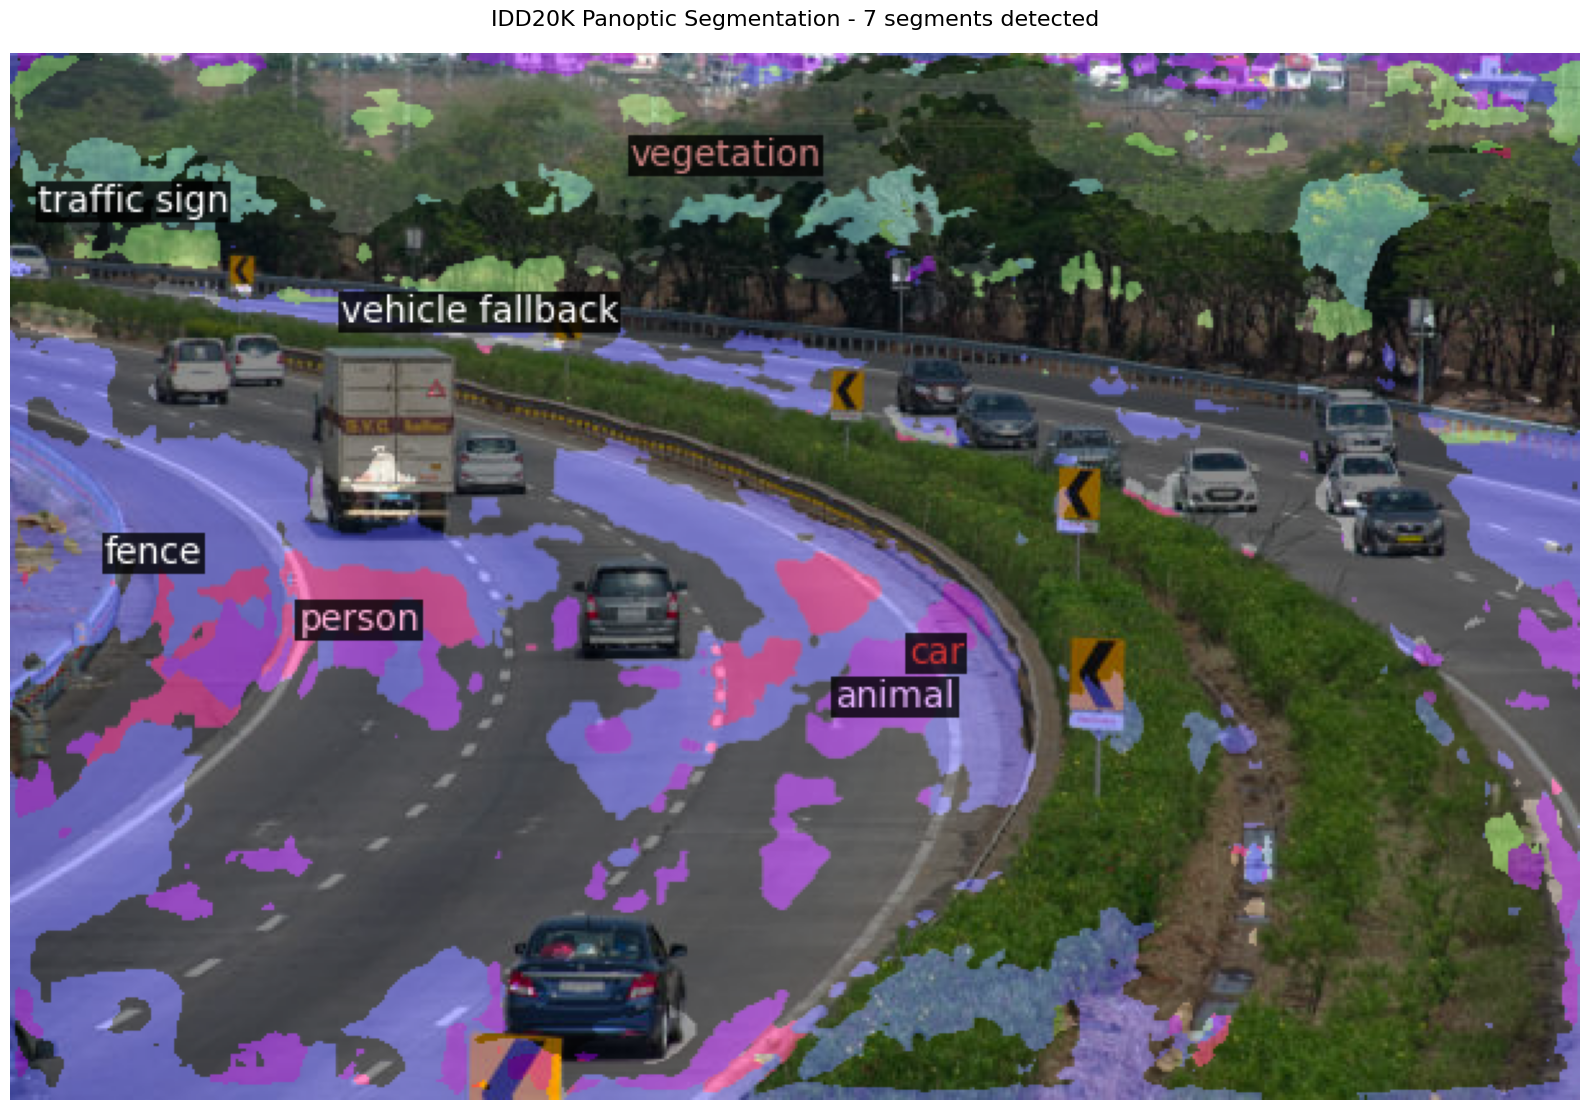


✓ Visualization saved to: D:/Detectron/idd20kII/output\prediction_visualization.png


In [ ]:
# if predictor and os.path.exists(test_image_path):
#     print("\n" + "="*80)
#     print("VISUALIZATION")
#     print("="*80)

#     metadata = MetadataCatalog.get(dataset_name)

#     # Print detected segments
#     print("\nDetected segments:")
#     print(f"{'Class':<30} {'Type':>6} {'Area (px)':>12}")
#     print("-" * 50)
#     for seg in segments_info:
#         cat_id = seg['category_id']
#         class_name = contiguous_id_to_class_name.get(cat_id, f"unknown_{cat_id}")
#         seg_type = "THING" if seg['isthing'] else "STUFF"
#         area = seg['area']
#         print(f"{class_name:<30} {seg_type:>6} {area:>12,}")

#     # Create visualization
#     v = Visualizer(
#         image[:, :, ::-1],
#         metadata=metadata,
#         scale=1.0
#     )

#     result = v.draw_panoptic_seg_predictions(
#         panoptic_seg.to("cpu"),
#         segments_info,
#         alpha=0.45,          # lower opacity
#         area_threshold=2000  # ignore tiny regions
#     )


#     # Display
#     plt.figure(figsize=(16, 12))
#     plt.imshow(result.get_image())
#     plt.axis('off')
#     plt.title(f"IDD20K Panoptic Segmentation - {len(segments_info)} segments detected",
#               fontsize=16, pad=20)
#     plt.tight_layout()
#     plt.savefig(os.path.join(cfg.OUTPUT_DIR, 'prediction_visualization.png'),
#                 dpi=150, bbox_inches='tight')
#     plt.show()

#     print(f"\n✓ Visualization saved to: {os.path.join(cfg.OUTPUT_DIR, 'prediction_visualization.png')}")
#     print("="*80)

In [28]:
print("Thing classes:", thing_class_names)
print("Max thing ID:", max(thing_name_to_id.values()))
print("ROI NUM_CLASSES:", d2_cfg.MODEL.ROI_HEADS.NUM_CLASSES)


Thing classes: ['person', 'animal', 'rider', 'motorcycle', 'bicycle', 'autorickshaw', 'car', 'truck', 'bus', 'vehicle fallback', 'traffic sign']
Max thing ID: 10
ROI NUM_CLASSES: 11
